# Import Packages

In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
from sklearn.model_selection import train_test_split
# For Prediction:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
# For nice Plots
%matplotlib inline
plt.style.use('default')

# Model Averaging Class

In [2]:
import mpmath
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, X, y, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        if 'WindowLRatio' in kwargs.keys():
            self.WindowLRatio = kwargs['WindowLRatio'] 
        else:
            self.WindowLRatio = 20 
        if 'ModelSizes' in kwargs.keys():
            self.ModelSizes = kwargs['ModelSizes']
        else:
            self.ModelSizes = np.arange(self.MaxVars)
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in self.ModelSizes: 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if (num_elements == 1) or (num_elements-1 not in self.ModelSizes):
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = sm.OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/self.WindowLRatio):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == 2:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

# Read in the Data

In [3]:
dir_path = os.path.abspath("")
fname = dir_path+'\countrydf.csv'
countrydf = pd.read_csv(fname, encoding='latin-1')
countrydf = countrydf.drop(["Country", "Year"],axis=1)

# Prediction:

In [4]:
# Build a test set and training set

cols_to_standardize = countrydf.columns.drop(['Future Undernourishment'])
scaler = StandardScaler()
countrydf[cols_to_standardize] = scaler.fit_transform(countrydf[cols_to_standardize])

# Print the standardized dataframe
#print(countrydf)

X_train, X_test, y_train, y_test = train_test_split(
  countrydf.drop(["Future Undernourishment"], axis=1), countrydf["Future Undernourishment"], test_size=1/3, random_state = 42)

# Replace all the NaNs with the column mean, 
# and build the test set and training set using the indicies from the first set
countrydf2 = countrydf.fillna(countrydf.mean())
# Build a test set and training set
X_train2 = countrydf2.drop(["Future Undernourishment"], axis=1).iloc[X_train.index]
X_test2 = countrydf2.drop(["Future Undernourishment"], axis=1).iloc[X_test.index]
y_train2 = countrydf2["Future Undernourishment"].iloc[y_train.index]
y_test2 = countrydf2["Future Undernourishment"].iloc[y_test.index]

# Use only rows with non-NaN response variable, then replace all the NaNs with the column mean 
# and build the test set and training set using the indicies from the first set
keep_indices_test = np.where(y_test.notna())
keep_indices_train = np.where(y_train.notna())
# Build a test set and training set
X_train3 = X_train2.iloc[keep_indices_train]
X_test3 = X_test2.iloc[keep_indices_test]
y_train3 = y_train2.iloc[keep_indices_train]
y_test3 = y_test2.iloc[keep_indices_test]

## 0. Baseline: Using previous year's undernouishment to predict next year

In [5]:
Future_Undernourishment_Col_Name = "Prevalence of undernourishment (percent) (3-year average)"
y_hat_baseline = X_test[Future_Undernourishment_Col_Name]*0
RMSE_baseline = np.sqrt((np.sum(y_hat_baseline-y_test)**2)/len(y_hat_baseline))
print("Baseline RMSE: "+str(RMSE_baseline))

Baseline RMSE: 4.295427155062048


In [6]:
y_hat_baseline2 = X_test2[Future_Undernourishment_Col_Name]*0
RMSE_baseline2 = np.sqrt((np.sum(y_hat_baseline2-y_test2)**2)/len(y_hat_baseline2))
print("Baseline RMSE2 (replacing all NaNs with mean): "+str(RMSE_baseline2))

Baseline RMSE2 (replacing all NaNs with mean): 5.370450254368094


In [7]:
y_hat_baseline3 = X_test3[Future_Undernourishment_Col_Name]*0
RMSE_baseline3 = np.sqrt((np.sum(y_hat_baseline3-y_test3)**2)/len(y_hat_baseline3))
print("Baseline RMSE3 (removing NaN in repsonse, then replacing all NaNs with mean): "+str(RMSE_baseline3))

Baseline RMSE3 (removing NaN in repsonse, then replacing all NaNs with mean): 4.932604391250738


## 1. Bayesian Model Averaging

In [8]:
nFeats = np.shape(countrydf)[1]
regr = BMA(X_train2, y_train2, Verbose=1, ModelSizes=[1,2,3,4,nFeats-3,nFeats-2,nFeats-1,nFeats], WindowLRatio=5)
#regr = RandomForestRegressor(random_state = 42)
# Train on the training set
regr.fit()
# predict using the test set
y_hat_BMA2 = regr.predict(X_test2)
# Compute the RMSE error
RMSE_BMA2 = np.sqrt((np.sum(y_hat_BMA2-y_test2)**2)/len(y_hat_BMA2))
print("Baseline RMSE2: "+str(RMSE_baseline2))
print("Bayesian Model Averaging RMSE2: "+str(RMSE_BMA2))

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 3.08845253957411327797274825905103480559471306422e-561
Model Variables: (1,) likelihood= 3.1153535591833206226789142728905832879376793132299e-561
Model Variables: (2,) likelihood= 3.1080494779599572146199328289824916937871369792283e-561
Model Variables: (3,) likelihood= 2.2291487525950267595264780289613978911273846957076e-558
Model Variables: (4,) likelihood= 1.2166479117175230948789134277857218410211597200623e-558
Model Variables: (7,) likelihood= 1.207185524263887789915087563188887697675835527148e-558
Model Variables: (10,) likelihood= 2.642994697690766832062037957032767768870530675167e-557
Computing BMA for models of size:  2
Model Variables: [1, 2] likelihood= 4.336202365424819102251239865785650447168659836876e-553
Computing BMA for models of size:  3
Model Variables: [0, 1, 2] likelihood= 5.7379044258445250704793690942672797404847818405755e-553
Model Variables: [1, 2, 3] likelihood= 3.59052552862045744494876779

In [9]:
summary2 = regr.summary()
summary2= summary2.sort_values(by='Probability', ascending=False)
summary2.head(20)

,Variable Name,Probability,Avg. Coefficient
1,level_0,1.0,212.227228
2,index,1.0,-211.723253
46,Number of newborns with low birthweight (million),0.881624,-0.231005
10,Prevalence of undernourishment (percent) (3-ye...,0.390814,-0.069656
9,"Gross domestic product per capita, PPP, (const...",0.151325,-0.032657
7,Average supply of protein of animal origin (g/...,0.11245,0.021326
34,Percentage of children under 5 years affected ...,0.0848,-0.024315
3,Average dietary energy supply adequacy (percen...,0.081828,0.01108
0,Unnamed: 0,0.07378,-0.506687
4,Dietary energy supply used in the estimation o...,0.034237,0.003991


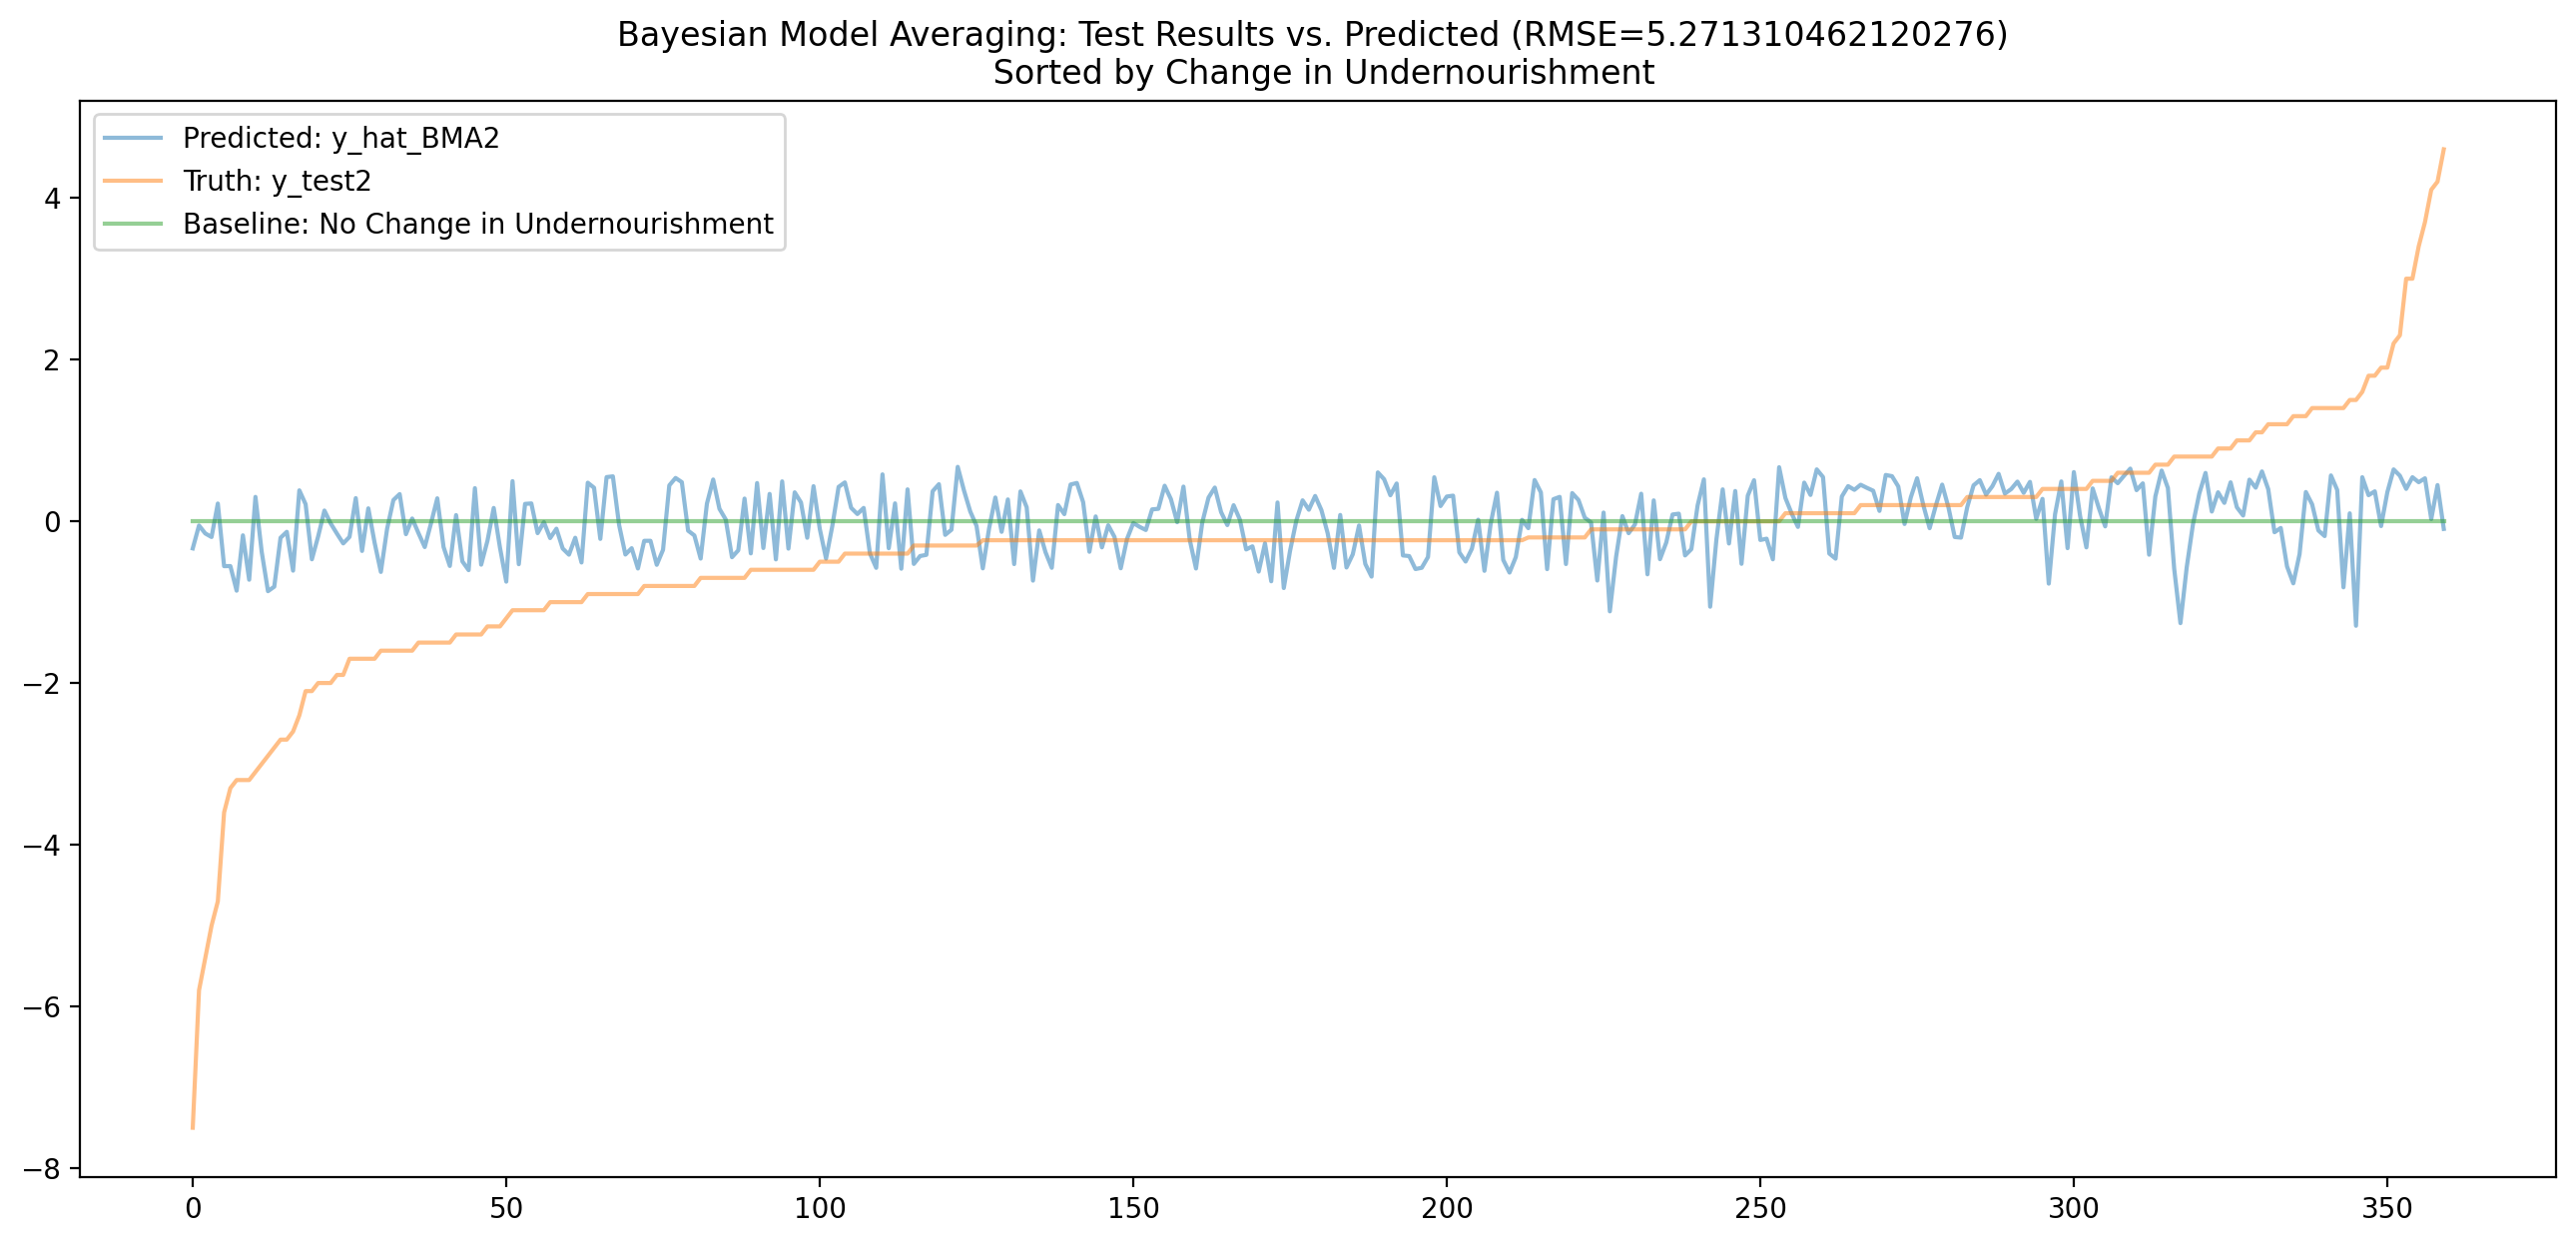

In [10]:
sorted_Idx = np.argsort(y_test2.to_numpy())
plt.figure(figsize=(16, 7), dpi=200)
plt.plot(y_hat_BMA2[sorted_Idx], label='Predicted: y_hat_BMA2', alpha=0.5)
plt.plot(y_test2.to_numpy()[sorted_Idx], label='Truth: y_test2', alpha=0.5)
plt.plot(y_hat_baseline2.to_numpy()[sorted_Idx], label='Baseline: No Change in Undernourishment', alpha=0.5)
plt.title("Bayesian Model Averaging: Test Results vs. Predicted (RMSE="+str(RMSE_BMA2)+") \n Sorted by Change in Undernourishment")
plt.legend();

In [11]:
nFeats = np.shape(countrydf)[1]
regr = BMA(X_train3, y_train3, Verbose=1, ModelSizes=[1,2,3,4,nFeats-3,nFeats-2,nFeats-1,nFeats], WindowLRatio=5)
#regr = RandomForestRegressor(random_state = 42)
# Train on the training set
regr.fit()
# predict using the test set
y_hat_BMA3 = regr.predict(X_test3)
# Compute the RMSE error
RMSE_BMA3 = np.sqrt((np.sum(y_hat_BMA3-y_test3)**2)/len(y_hat_BMA3))
print("Baseline RMSE2: "+str(RMSE_baseline3))
print("Bayesian Model Averaging RMSE3: "+str(RMSE_BMA3))

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 1.3842357173369073876230696961349286452299097900242e-468
Model Variables: (1,) likelihood= 1.4183245590440419426029773107337190300905458592875e-468
Model Variables: (2,) likelihood= 1.4100937780157656694443342880178634333929862770685e-468
Model Variables: (3,) likelihood= 2.1558781887214739601156166131437087810738297575964e-466
Model Variables: (4,) likelihood= 1.339020034391554632504304061226837929860676595084e-466
Model Variables: (7,) likelihood= 1.3308222266873104742899997796596041490950118605993e-466
Model Variables: (10,) likelihood= 1.5078059098125596658790794658963813697886970605808e-465
Model Variables: (40,) likelihood= 8.275176685761401805834417343334906113940823954465e-466
Computing BMA for models of size:  2
Model Variables: [1, 2] likelihood= 4.9719933815334739951474326807441251108750448291033e-460
Computing BMA for models of size:  3
Model Variables: [0, 1, 2] likelihood= 7.804526325913385293575865135

In [12]:
summary3 = regr.summary()
summary3= summary3.sort_values(by='Probability', ascending=False)
summary3.head(20)

,Variable Name,Probability,Avg. Coefficient
1,level_0,1.0,287.836417
2,index,1.0,-287.171705
46,Number of newborns with low birthweight (million),0.714158,-0.230059
9,"Gross domestic product per capita, PPP, (const...",0.344856,-0.171388
7,Average supply of protein of animal origin (g/...,0.262347,0.08901
34,Percentage of children under 5 years affected ...,0.167113,-0.064151
27,Political stability and absence of violence/te...,0.104884,-0.018488
0,Unnamed: 0,0.075928,-0.642137
40,Prevalence of obesity in the adult population ...,0.07466,0.013243
10,Prevalence of undernourishment (percent) (3-ye...,0.06896,-0.010032


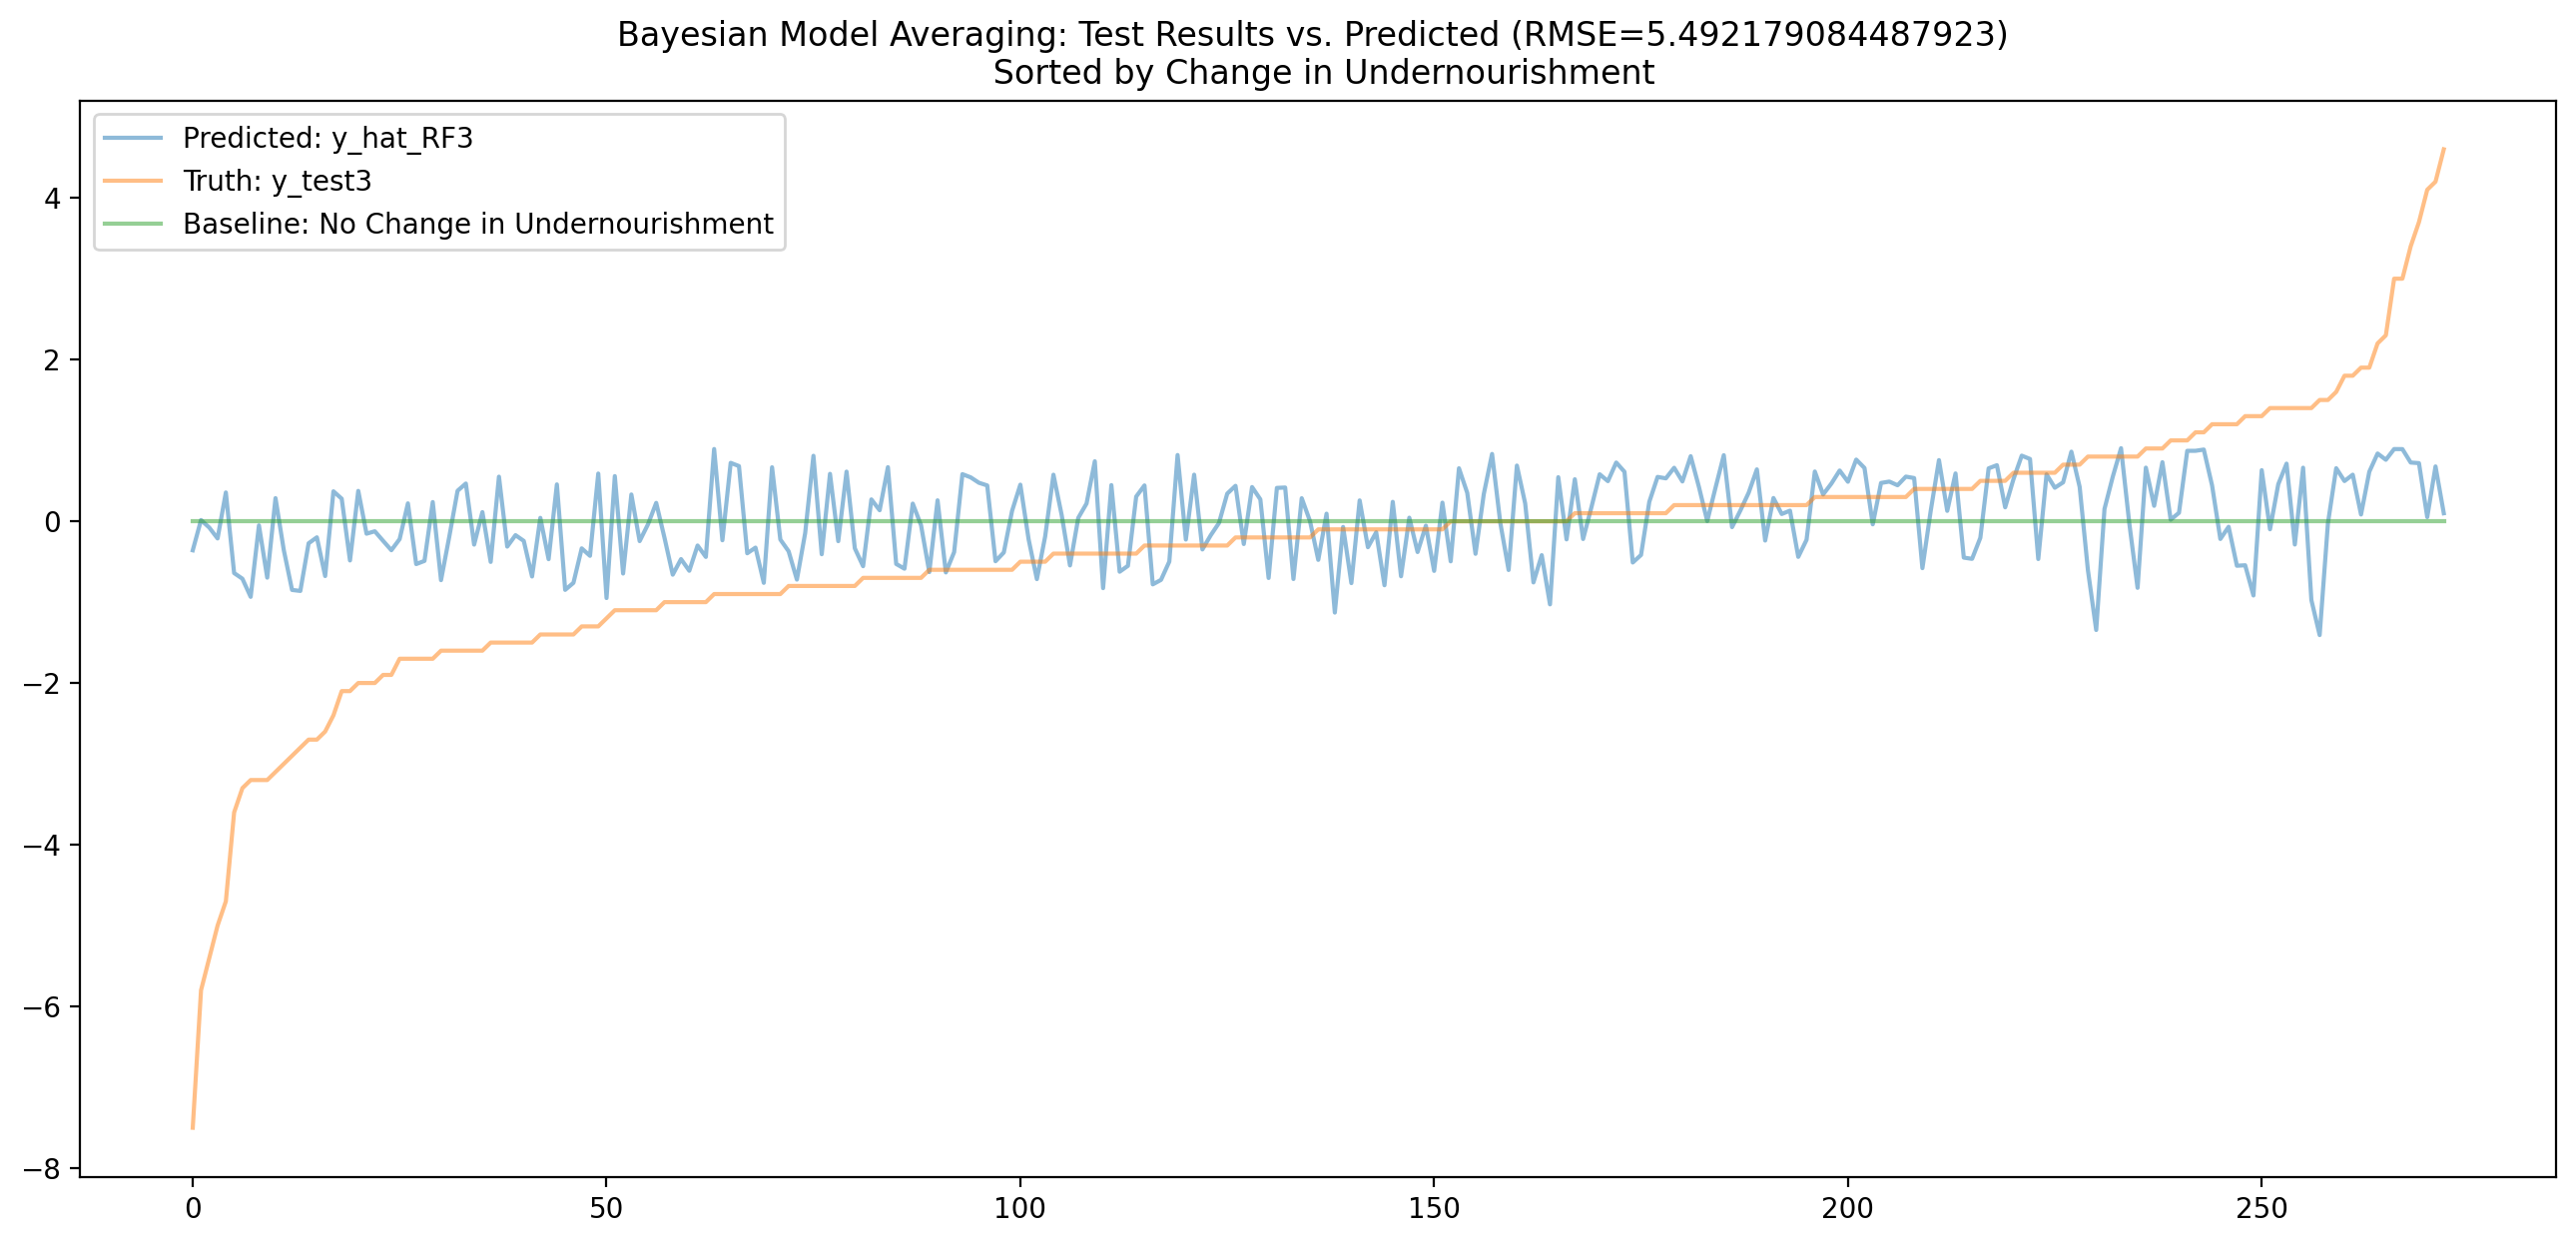

In [13]:
sorted_Idx = np.argsort(y_test3.to_numpy())
plt.figure(figsize=(16, 7), dpi=200)
plt.plot(y_hat_BMA3[sorted_Idx], label='Predicted: y_hat_RF3', alpha=0.5)
plt.plot(y_test3.to_numpy()[sorted_Idx], label='Truth: y_test3', alpha=0.5)
plt.plot(y_hat_baseline3.to_numpy()[sorted_Idx], label='Baseline: No Change in Undernourishment', alpha=0.5)
plt.title("Bayesian Model Averaging: Test Results vs. Predicted (RMSE="+str(RMSE_BMA3)+") \n Sorted by Change in Undernourishment")
plt.legend();

# Feature Importance

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


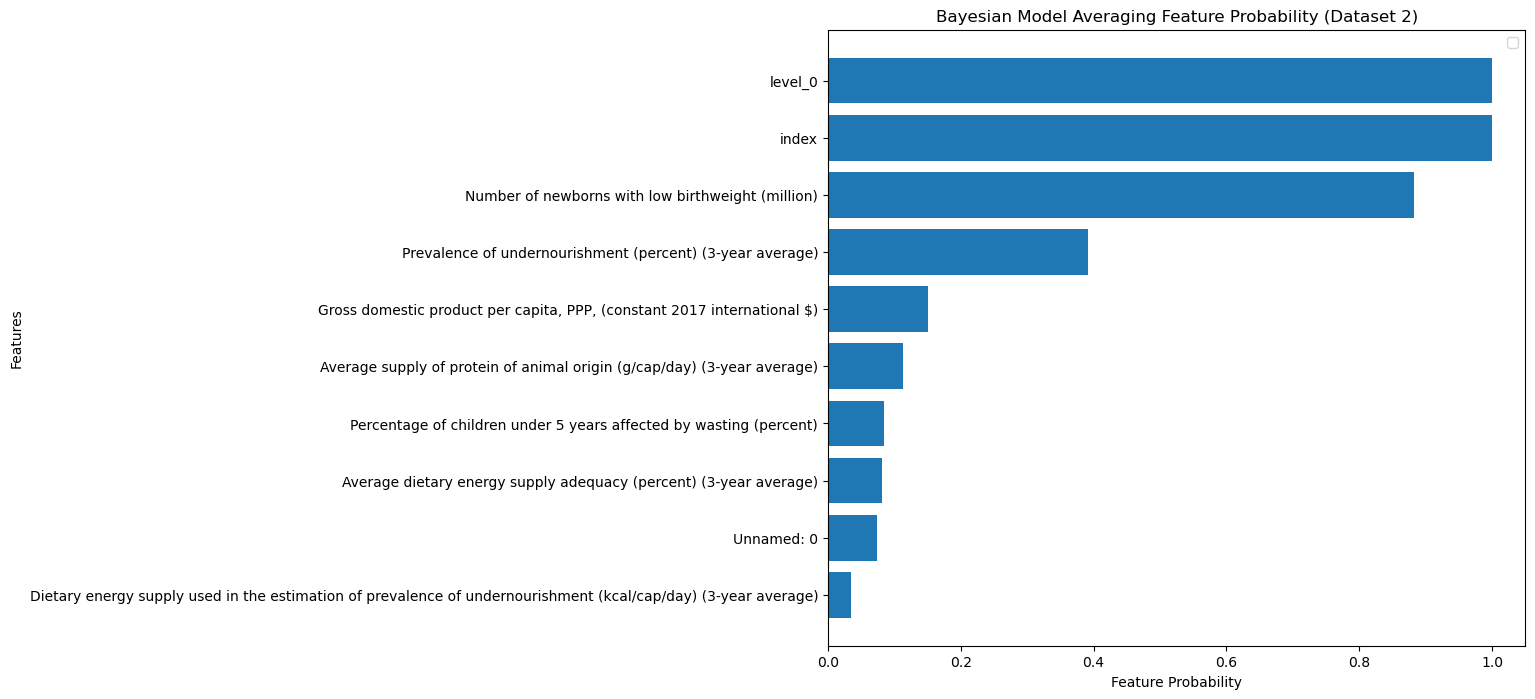

In [14]:
#plt.barh(secFet, regr.feature_importances_)
#Develope Feature Importance
fig, ax = plt.subplots(figsize=(9, 8))
#Drop the bottom 50 Features
summary_plot = summary2.sort_values(by='Probability', ascending=False).head(10)
summary_plot = summary_plot.sort_values(by='Probability', ascending=True)
#Plot the Feature Importance
ax.barh(summary_plot['Variable Name'], summary_plot['Probability'])
#plt.barh(secFet[sorted_regr], regr.feature_importances_[sorted_regr])
plt.title("Bayesian Model Averaging Feature Probability (Dataset 2)")
plt.xlabel('Feature Probability')
plt.ylabel('Features')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


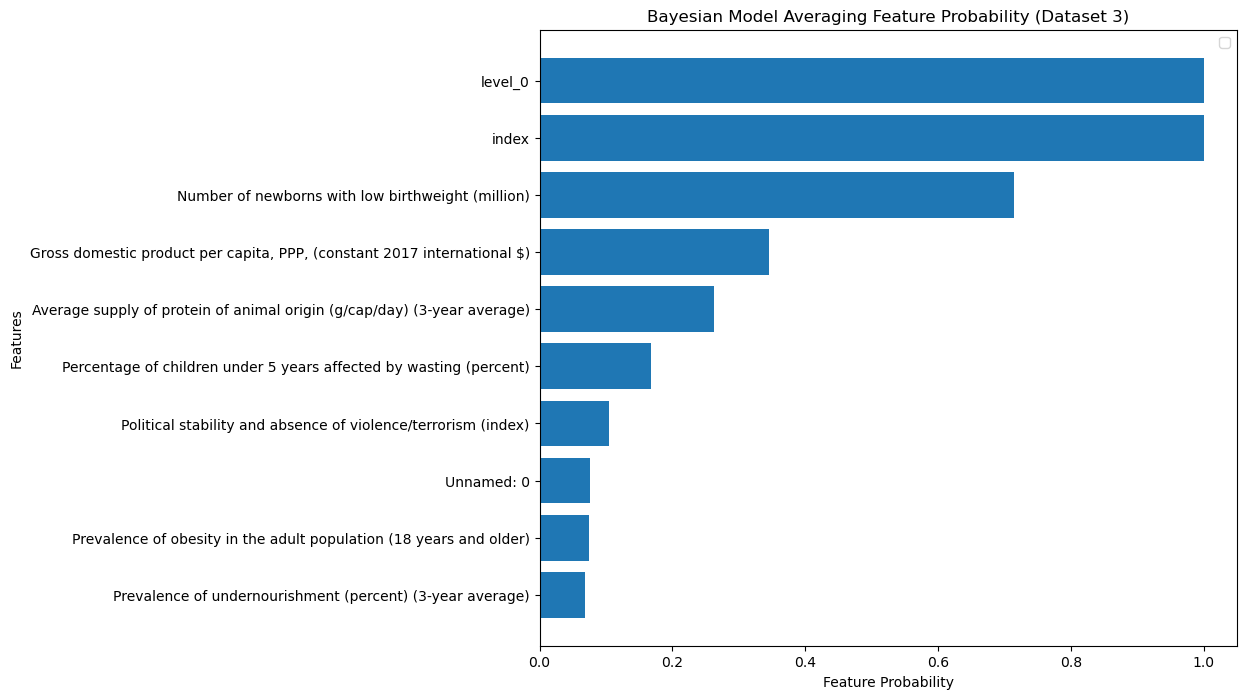

In [15]:
#plt.barh(secFet, regr.feature_importances_)
#Develope Feature Importance
fig, ax = plt.subplots(figsize=(9, 8))
#Drop the bottom 50 Features
summary_plot = summary3.sort_values(by='Probability', ascending=False).head(10)
summary_plot = summary_plot.sort_values(by='Probability', ascending=True)
#Plot the Feature Importance
ax.barh(summary_plot['Variable Name'], summary_plot['Probability'])
#plt.barh(secFet[sorted_regr], regr.feature_importances_[sorted_regr])
plt.title("Bayesian Model Averaging Feature Probability (Dataset 3)")
plt.xlabel('Feature Probability')
plt.ylabel('Features')
plt.legend()
plt.show()